In [1]:
%matplotlib inline
from pprint import pprint
from metrics import wer, cew, ssr, average, hreff
import montecarlo
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import N_100_RebalanceHarvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

In [2]:
from metrics import cew
w = []
x = 70000
for i in range(40):
    w.append(x)
    x -= 1000
print(cew(w))
pprint(w)

43878.36543435396250313061898
[70000,
 69000,
 68000,
 67000,
 66000,
 65000,
 64000,
 63000,
 62000,
 61000,
 60000,
 59000,
 58000,
 57000,
 56000,
 55000,
 54000,
 53000,
 52000,
 51000,
 50000,
 49000,
 48000,
 47000,
 46000,
 45000,
 44000,
 43000,
 42000,
 41000,
 40000,
 39000,
 38000,
 37000,
 36000,
 35000,
 34000,
 33000,
 32000,
 31000]


In [3]:
survival_function = mortality.make_mortality(mortality.ANNUITY_2000)

In [4]:
def run_one(rate, basecase, withdrawal_strategy):
    # The montecarlo used above has the stock/bond split baked in
    # So we pretend we have a 100% stock portfolio in order to handle
    # harvesting of cash
    p = Portfolio(1000000, 0)
    h = N_100_RebalanceHarvesting(p).harvest()
    h.send(None)
    w = withdrawal_strategy(p, h, rate=rate).withdrawals()

    cashflows = []
    returns = []
    
    # the previous year's returns
    x = None

    # Couple is assumed to be age 65 (one male, one female)
    age = mortality.gen_age(survival_function)
    for i in range(age - 65 + 1):
        # Withdrawals happen at the start of the year
        # So we first withdraw cash.
        cashflows.append(w.send(x).withdraw_pct_orig)
        
        # Then the year happens and we store the returns
        x = basecase.random_year()
        returns.append(x.stocks)

    w = wer(cashflows, returns, fudge=D('.02'))
    h = hreff(cashflows, returns, floor=D('.03'))
    return (w, h)

In [5]:
runs = 1000
dataset = montecarlo.conservative[60]

In [6]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), dataset, withdrawal.RetrenchmentRule))
retrench_wer = average([w[0] for w in wers])
retrench_hreff = average([w[1] for w in wers])

In [7]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), dataset, withdrawal.VPW))
vpw_wer = average([w[0] for w in wers])
vpw_hreff = average([w[1] for w in wers])

In [8]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), dataset, withdrawal.ConstantPercentage))
endowment_wer = average([w[0] for w in wers])
endowment_hreff = average([w[1] for w in wers])

In [9]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), dataset, withdrawal.ConstantWithdrawals))
swr_wer = average([w[0] for w in wers])
swr_hreff = average([w[1] for w in wers])

In [10]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), dataset, withdrawal.EM))
em_wer = average([w[0] for w in wers])
em_hreff = average([w[1] for w in wers])

In [11]:
wers = []
for i in range(runs):
    wers.append(run_one(D('.04'), dataset, withdrawal.SimpleFormula))
simple_wer = average([w[0] for w in wers])
simple_hreff = average([w[1] for w in wers])

Constant 4%    0.691211
EM             0.804875
Endowment      0.729531
Retrench       0.770409
Simple         0.774867
VPW            0.820265
dtype: float64


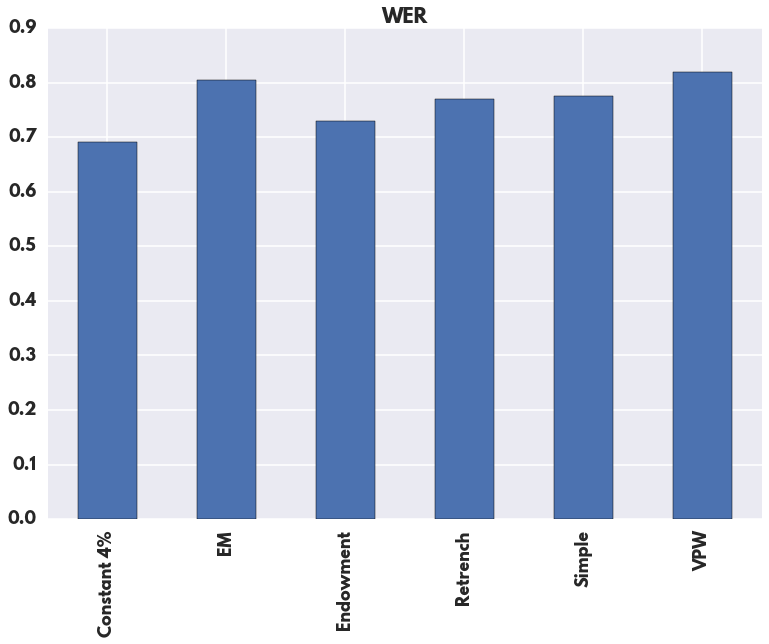

In [12]:
series = pandas.Series({
    'Constant 4%' : swr_wer,
    'Endowment' : endowment_wer,
    'EM' : em_wer,
    'VPW' : vpw_wer,
    'Simple' : simple_wer,
    'Retrench' : retrench_wer,
})

series.plot(kind='bar', title='WER')
print(series)

Constant 4%    0.578051
EM             0.768392
Endowment      0.697679
Retrench       0.812036
Simple         0.851843
VPW            0.850913
dtype: float64


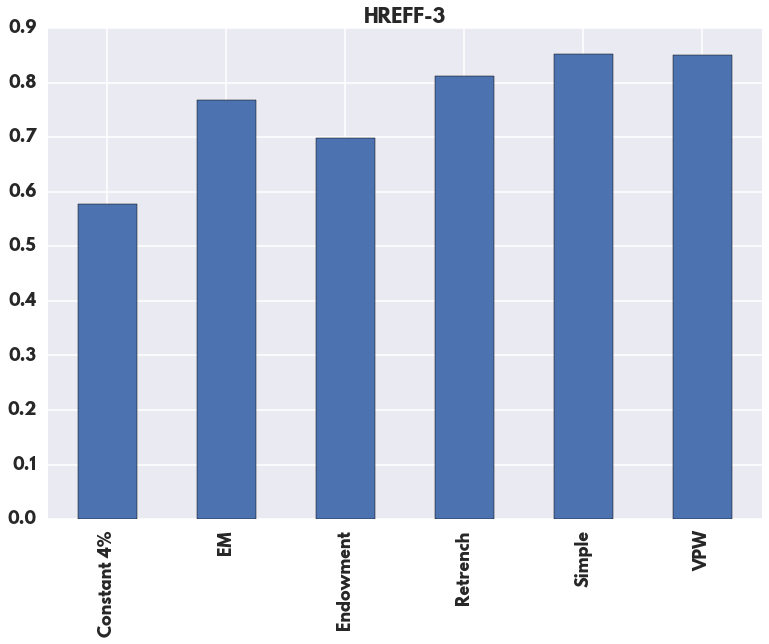

In [13]:
series = pandas.Series({
    'Constant 4%' : swr_hreff,
    'Endowment' : endowment_hreff,
    'EM' : em_hreff,
    'VPW' : vpw_hreff,
    'Simple' : simple_hreff,
    'Retrench' : retrench_hreff,
})

series.plot(kind='bar', title='HREFF-3')
print(series)

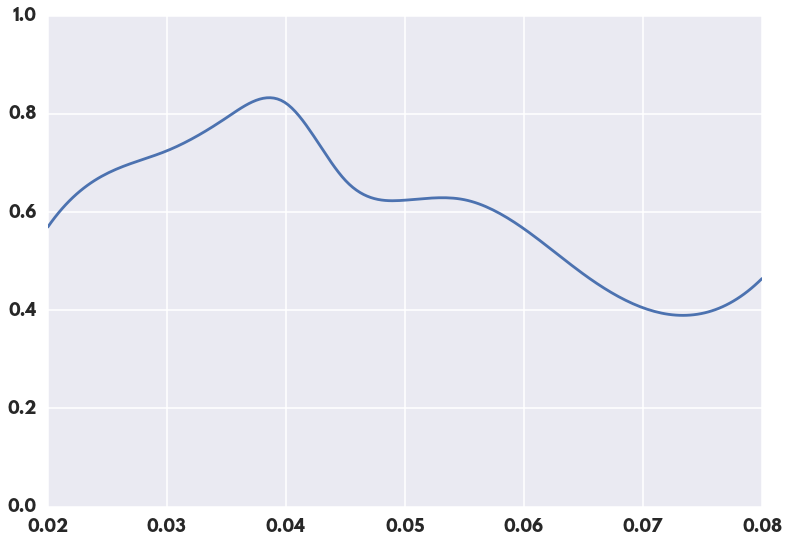

In [14]:
from scipy.interpolate import spline
import numpy as np

#canvas = plt.figure()

for equity in [0]:
    w = []
    r = []
    for rate in range(20, 81, 5):
        rate = D(rate) / 1000
        case = montecarlo.conservative[equity]

        wers = []
        for i in range(10):
            wers.append(run_one(rate, case, withdrawal.ConstantWithdrawals))
        my_wer = average([w[0] for w in wers])
        w.append(my_wer)
        r.append(rate)

    x_smooth = np.linspace(float(min(r)), float(max(r)), 200)
    y_smooth = spline(r, w, x_smooth)

    fig, ax1 = plt.subplots()
    ax1.set_ylim((0,1))
    plt.plot(x_smooth, y_smooth)